In [14]:
import sys
sys.path.insert(0,'C:\\Coding\\Local_repositories\\Exammmmm\\')

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

import seaborn as sns
sns.set_theme()

from codelib.visualization.base import fan_chart

# The Cox-Ingersoll-Ross model

In [15]:
# 

r_0 = 0.02
kappa = 0.36
theta = 0.08
beta = 0.1
weeks_per_year = 52
years = 10

weeks_total = weeks_per_year * years
delta_t = 1 / weeks_per_year # Weekly time steps

num_sim = 10000

# Simulating standard normal random variables
dz = np.random.normal(loc = 0, scale = np.sqrt(delta_t), size = (num_sim, weeks_total))

In [16]:
# Short rate loop

short_rate = np.empty(shape = (num_sim, weeks_total + 1))

for i in range(weeks_total + 1):
    if i == 0:
        short_rate[:, i] = r_0
    else:
        short_rate[:, i] = short_rate[:, i - 1] + kappa * (theta - short_rate[:, i - 1]) * delta_t + beta * np.sqrt(short_rate[:, i - 1]) * dz[:, i - 1]

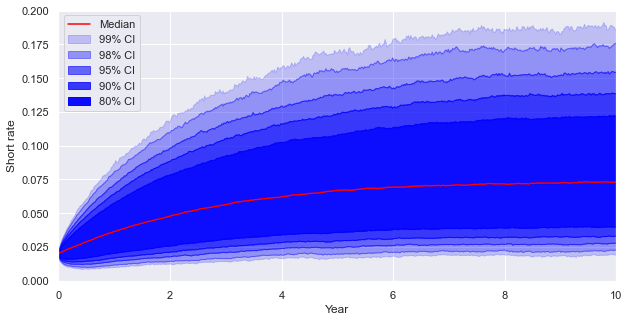

In [17]:
# Plot of short rate

x = np.linspace(0, 10, weeks_total + 1)

percentiles_CIR = np.percentile(short_rate, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 5))

fan_chart(x,
          percentiles_CIR,
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax = ax)

ax.set_xlabel("Year")
ax.set_ylabel("Short rate")
ax.set_xlim(0, 10)
ax.legend(loc='upper left');

In [18]:
# Test of mean and variance of short rate at year 10

def expected_CIR_shortrate(theta, r_t, kappa, t, s):
    return theta + (r_t - theta) * np.exp(-kappa * (s - t))

def var_CIR_shortrate(beta, r_t, kappa, t, s):
    return ((beta**2 * r_t) / kappa) * (np.exp(-kappa * (s - t)) - np.exp(-2 * kappa * (s - t))) + ((beta ** 2 * theta) / (2 * kappa)) * (1 - np.exp(-kappa * (s - t))) ** 2


In [19]:
# Expected value

print("Expected CIR short rate at year 10: " + str(expected_CIR_shortrate(theta, r_0, kappa, 0, 10)))
print("Simulated CIR short rate mean at year 10: " + str(short_rate[:, -1].mean()))

Expected CIR short rate at year 10: 0.07836057665316244
Simulated CIR short rate mean at year 10: 0.07796584415965468


In [20]:
# Mean

print("Variance CIR short rate at year 10: " + str(var_CIR_shortrate(beta, r_0, kappa, 0, 10)))
print("Simulated CIR short rate variance at year 10: " + str(short_rate[:, -1].var(ddof = 1)))

Variance CIR short rate at year 10: 0.0010659863435924998
Simulated CIR short rate variance at year 10: 0.0010801858598256655


In [21]:
# Calculating zero-coupon bond prices with face value 1 using the CIR-model

def ZCB_t(t, T, r_t, kappa_hat, theta_hat, beta, price = False):
    
    """Calculates price or yield of a ZCB at time t with TTM = T - t using the CIR short rate model."""
    
    gamma = np.sqrt(kappa_hat ** 2 + 2 * beta ** 2)
    a = -((2 * kappa_hat * theta_hat) / beta ** 2) * (np.log(2 * gamma) + 0.5 * (kappa_hat + gamma) * (T - t) - np.log((gamma + kappa_hat) * (np.exp(gamma * (T - t)) - 1) + 2 * gamma))
    b = (2 * (np.exp(gamma * (T - t)) - 1)) / ((gamma + kappa_hat) * (np.exp(gamma * (T - t)) - 1) + 2 * gamma)
    if price == True:
        return 1 * np.exp(-a - b * r_t)
    if price == False:
        ZCB_price = np.exp(-a - b * r_t)
        return (1 / (T - t)) * np.log(1 / ZCB_price)

In [22]:
# Creating zero coupon yields

lambd = 0
kappa_hat = kappa + lambd
theta_hat = (kappa * theta) / (kappa + lambd)

T = np.linspace(0.1, 10, 100)

ZCB_yield = np.empty(shape = 100)
ZCB_price = np.empty(shape = 100)

for i, j in zip(T, range(100)):
    ZCB_yield[j] = ZCB_t(0, i, r_0, kappa_hat, theta_hat, beta) 
    ZCB_price[j] = ZCB_t(0, i, r_0, kappa_hat, theta_hat, beta, price = True) 

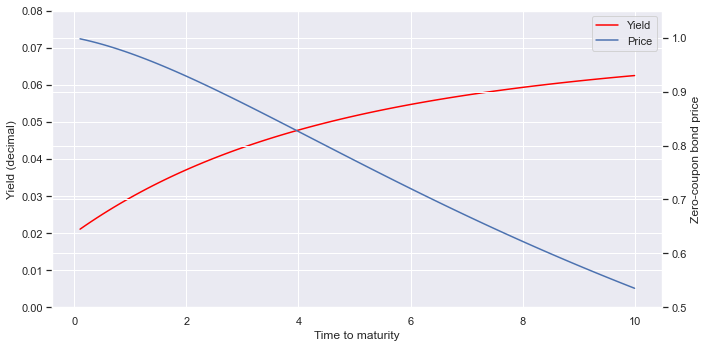

In [23]:
labels = ["Yield", "Price"]

fig, ax = plt.subplots(figsize = (10, 5))

yields = ax.plot(T, ZCB_yield, label = labels[0], color = "red")
ax.set_ylim(0, 0.08)

ax2 = ax.twinx()

prices = ax2.plot(T, ZCB_price, label = labels[1])
ax2.set_ylim(0.5, 1.05)

plt.legend(yields + prices, labels, loc = 0)
ax.set_xlabel("Time to maturity")
ax.set_ylabel("Yield (decimal)")
ax2.set_ylabel("Zero-coupon bond price")
fig.tight_layout()
plt.show()

In [41]:
# Loading cash flow data

data = pd.read_excel("C:\\Coding\\Local_repositories\\Exammmmm\\ExamData\\cashflow.xlsx", usecols = [0, 1])

# Calculating ZCB prices and yields for maturities 1, 2, ..., 10

ZCB_prices_1to10 = np.empty(shape = 10)
ZCB_yields_1to10 = np.empty(shape = 10) 

for i in range(10):
    ZCB_prices_1to10[i] = ZCB_t(0, i + 1, r_0, kappa_hat, theta_hat, beta, price = True)
    ZCB_yields_1to10[i] = ZCB_t(0, i + 1, r_0, kappa_hat, theta_hat, beta, price = False)

In [44]:
# Combining into one dataframe

cashflows_pd = pd.concat([data, pd.Series(ZCB_prices_1to10), pd.Series(ZCB_yields_1to10)], axis = 1).rename(columns = {"time (T)" : "Time", "cf" : "Cash flow", 0 : "Price", 1 : "Yield"})

# Calculating present values of cash flows using 1) ZCB prices and 2) ZCB yields

cashflows_pd["PV"] = cashflows_pd["Cash flow"] * cashflows_pd["Price"]
cashflows_pd["PV2"] = cashflows_pd["Cash flow"] * np.exp(-cashflows_pd["Yield"] * cashflows_pd["Time"])

# Total present value of cash flows

PV_total = cashflows_pd["PV"].sum()

# Show 
PV_total

5113621.302359084